In [267]:
# import necessary packages

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.model_selection import KFold # k-fold cv
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

%precision %.7g
%matplotlib inline

## 7. Using years and IMDB user score, which clustering models (K means, Gaussian Mixture Models, Hierarchical Clustering, or DBSCAN) would create the best clusters for our dataset?

### 7a) the analysis code

In [268]:
data = pd.read_csv("https://raw.githubusercontent.com/tarekel96/MoviesData/master/movies.csv")
data.head()

budget                                 company country        director  \
0   8000000           Columbia Pictures Corporation     USA      Rob Reiner   
1   6000000                      Paramount Pictures     USA     John Hughes   
2  15000000                      Paramount Pictures     USA      Tony Scott   
3  18500000  Twentieth Century Fox Film Corporation     USA   James Cameron   
4   9000000                    Walt Disney Pictures     USA  Randal Kleiser   

       genre  genre_encoded      gross                      name rating  \
0  Adventure              0   52287414               Stand by Me      R   
1     Comedy              1   70136369  Ferris Bueller's Day Off  PG-13   
2     Action              2  179800601                   Top Gun     PG   
3     Action              2   85160248                    Aliens      R   
4  Adventure              0   18564613   Flight of the Navigator     PG   

   rating_encoded    released  runtime  score               star   votes  \
0               3  1986-08-22       89    8.1        Wil Wheaton  299174   
1               2  1986-06-11      103    7.8  Matthew Broderick  264740   
2               1  1986-05-16      110    6.9         Tom Cruise  236909   
3               3  1986-07-18      137    8.4   Sigourney Weaver  540152   
4               1  1986-08-01       90    6.9        Joey Cramer   36636   

          writer  year released  
0   Stephen King           1986  
1    John Hughes           1986  
2       Jim Cash           1986  
3  James Cameron           1986  
4  Mark H. Baker           1986

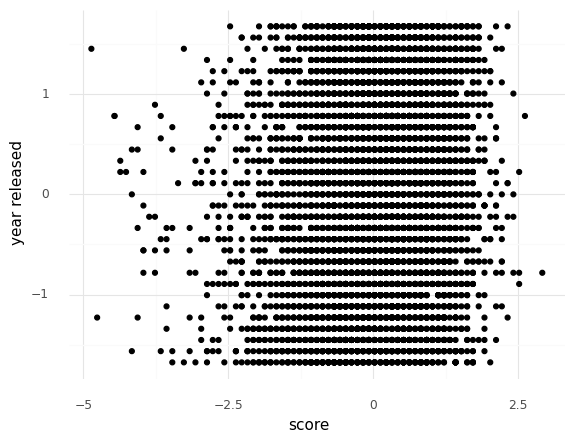

<ggplot: (8778071254643)>

In [269]:
features = ["year released", "score"]
X = data[features]

z = StandardScaler()
X[["year released", "score"]] = z.fit_transform(X)

(ggplot(X, aes("score", "year released")) + geom_point() + theme_minimal())

## GMM

In [274]:
#features = ["year released","score"]
#X = data[features]

#z = StandardScaler()
#X[features] = z.fit_transform(X)

In [275]:
EM = GaussianMixture(n_components = 2)
EM.fit(X)

GaussianMixture(n_components=2)

In [276]:
cluster = EM.predict(X)
cluster

array([0, 0, 0, ..., 1, 1, 1])

In [277]:
print("SILHOUETTE: ", silhouette_score(X, cluster))

SILHOUETTE:  0.3734669512890551


## DBSCAN

In [296]:
# dbscan and plot
db = DBSCAN(eps = 0.5, min_samples = 3).fit(X)

#noise cluster
labsList = ["Noise"]

#adding all other clusters to noise cluster 
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db.labels_)))]
X["assignments"] = db.labels_
(ggplot(X, aes(x = "score", y = "year released", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "DBSCAN with eps = 0.5, min_samples = 3"))


<ggplot: (8778064604925)>

In [297]:
# grab only clustered data points
#X_clustered = X.loc[(X.assignments >= 0)]

#print(silhouette_score(X_clustered[["year released","score"]], X_clustered["assignments"]))

# overall 
print(silhouette_score(X[["year released","score"]], X["assignments"]))

0.3671993578675423


### 7b) Explicit answer to the question with detailed responses of how you came to this answer and the answer's importance. This should be targeted at an audience that are NOT familiar with Data Science (e.g. pretend you're presenting these results to shareholders/your boss)

First, z-scoring our two variables, years and score, allows us to effectively compare them, even though they may initially have different distributions. In order to determine which supervised learning model would be best for our dataset, we need to first visualize our dataset itself and identify any patterns that may exist within it. Just by looking at the scatterplot after z-scoring, it seems like there are lots of outliers and overlapping data points. We think GMM would be one of the best methods because it assigns each data probability instead of assignment data point to clusters. We also think DBSCAN would be one of the best methods because it has a big advantage of approaching the noise. Also, it deals with weird shape cluster, so it is going to be good with this dataset. 

### 7c) Two ggplot data visualizations + captions (graphs will be graded on how efficient and clear they are, so make sure you make good aesthetic choices that help emphasize your message)

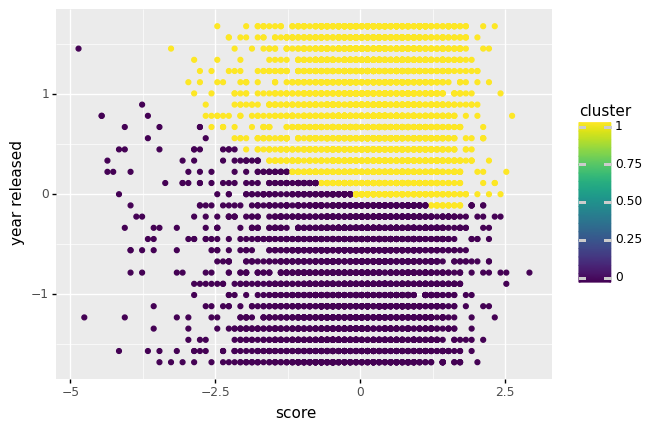

<ggplot: (8778071329347)>

In [280]:
#GMM

X["cluster"] = cluster

(ggplot(X, aes(x = "score", y = "year released", color = "cluster")) + geom_point())

In [295]:
# DBSCAN 

(ggplot(X, aes(x = "score", y = "year released", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "DBSCAN with eps = 0.5, min_samples = 3"))

<ggplot: (8778066971901)>

## 8. Assess the performance of the best model from question 7. Additionally, how is the model performance affected when runtime is added as a variable?

### 8a) The analysis code

In [282]:
new_features = ["year released", "score", "runtime"]
new_X = data[new_features]

z = StandardScaler()
new_X[new_features] = z.fit_transform(new_X)

new_X.head()

#(ggplot(X, aes("score", "year released")) + geom_point() + theme_minimal())

year released     score   runtime
0      -1.677164  1.719825 -0.973621
1      -1.677164  1.420743 -0.197002
2      -1.677164  0.523496  0.191308
3      -1.677164  2.018907  1.689073
4      -1.677164  0.523496 -0.918148

In [283]:
EM = GaussianMixture(n_components = 3)
EM.fit(new_X)

GaussianMixture(n_components=3)

In [284]:
cluster = EM.predict(new_X)
cluster

array([1, 1, 1, ..., 0, 0, 0])

In [285]:
print("SILHOUETTE: ", silhouette_score(new_X, cluster))

SILHOUETTE:  0.28822710394743983


In [286]:
new_X["cluster"] = cluster

### 8b) Explicit answer to the question with detailed responses of how you came to this answer and the answer's importance. This should be targeted at an audience that are NOT familiar with Data Science (e.g. pretend you're presenting these results to shareholders/your boss)

After adding another variable, runtime, z-scoring is allows to place runtime variable on the same distribution as the other variables as well as refit our model with all the variables. By generating a new silhouette score, we can tell that adding a new variable affected our original model’s performance. 

### 8c) Two ggplot data visualizations + captions (graphs will be graded on how efficient and clear they are, so make sure you make good aesthetic choices that help emphasize your message)

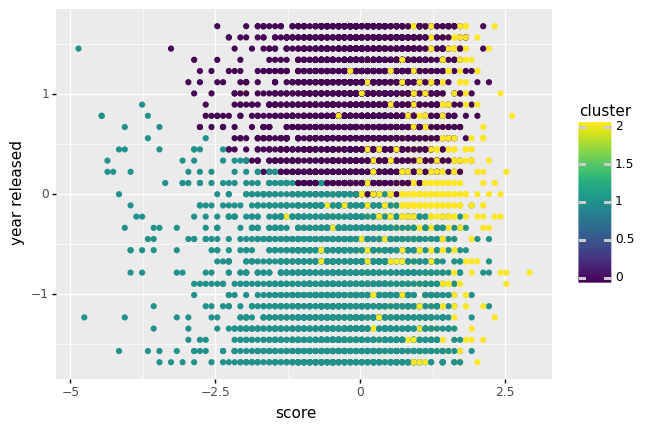

<ggplot: (8778069759088)>

In [287]:
# First ggplot (years on the x-axis and scores on the y-axis)

(ggplot(new_X, aes(x = "score", y = "year released", color = "cluster")) + geom_point())

In [306]:
# Second ggplot 

# make a new DF with just the probabilities above
group = ["Model 2 (with Runtime)","Model 1"] # column 1 of the df
score = [silhouette_score(X[["year released","score"]], X["assignments"]), 
         silhouette_score(new_X, cluster)] # column 2 of the df
myDF = {"Model": group, "Score": score} # create a dictionary for df
probDF = pd.DataFrame(myDF) # create the df using pandas
probDF.head()

Model     Score
0  Model 2 (with Runtime)  0.367199
1                 Model 1  0.381652

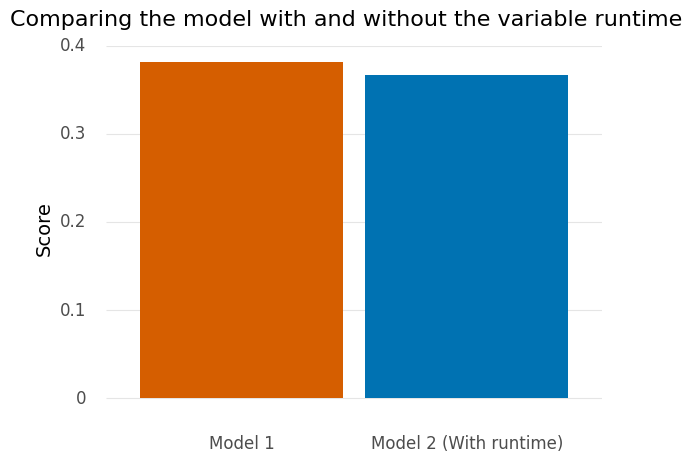

<ggplot: (8778069738825)>

In [318]:
(ggplot(probDF, aes(x = "Model", y = "Score", fill = "group")) + 
     geom_bar(stat="identity") + 
     theme_minimal() +
     labs(x = "", y = "Score") + 
     scale_x_discrete(labels = ("Model 1", "Model 2 (With runtime)")) +
     ggtitle("Comparing the model with and without the variable runtime") +
     scale_fill_manual(["#d55e00", "#0072b2"]) +
     theme(panel_grid_minor_x = element_blank(),
     panel_grid_minor_y = element_blank(), 
     panel_grid_major_x = element_blank(),
     axis_text_x = element_text(size = 12),
     axis_title_x = element_text(size = 14),
     axis_text_y = element_text(size = 12),
     axis_title_y = element_text(size = 14),
     plot_title = element_text(lineheight = 1.5, size = 16),
     legend_text = element_text(size = 12),
     legend_position = "none"))

Caption: Comparing the model with and without the variable runtime. As the graph shows, the model not including runtime variable has slightly higher silhouette score than the model that includes a runtime.

## 9) Using the model from question 8, create three scatter plots (years vs score, years vs runtime, score vs runtime) colored by cluster assignments. Describe what each cluster in each scatter plot represents

### 9a) The analysis code

No analysis code needed, just ggplots on part c.

### 9b) Explicit answer to the question with detailed responses of how you came to this answer and the answer's importance. This should be targeted at an audience that are NOT familiar with Data Science (e.g. pretend you're presenting these results to shareholders/your boss)

Coloring the clusters is important for us to help visualize the different clusters in each scatterplot. Scatterplot would be the best option because we want to view any relationships or patterns between the two variables in each
scatter plot. 

### 9c) Two ggplot data visualizations + captions (graphs will be graded on how efficient and clear they are, so make sure you make good aesthetic choices that help emphasize your message)

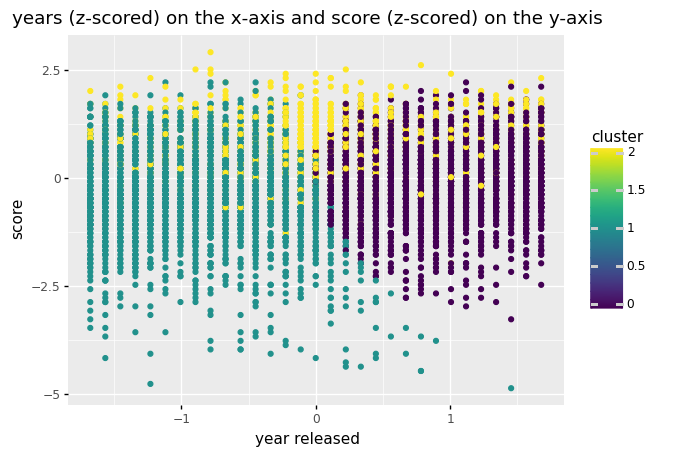

<ggplot: (8778139659638)>

In [324]:
# First ggplot

(ggplot(new_X, aes(x = "year released", y = "score", color = "cluster")) + geom_point()
 + ggtitle("years (z-scored) on the x-axis and score (z-scored) on the y-axis"))

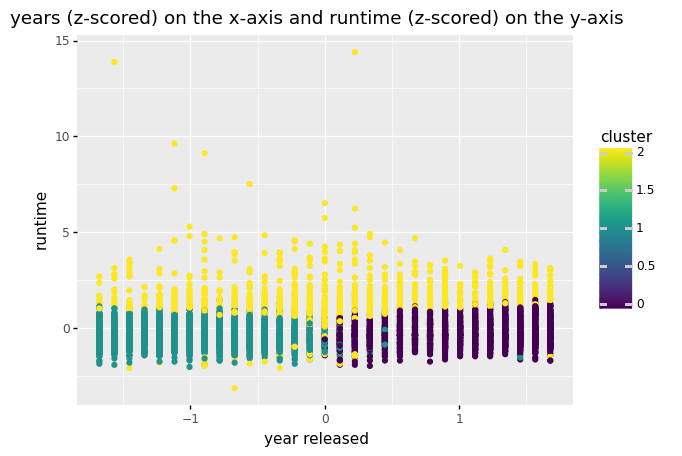

<ggplot: (8778066966158)>

In [325]:
# Second ggplot

(ggplot(new_X, aes(x = "year released", y = "runtime", color = "cluster")) + geom_point()
+ ggtitle("years (z-scored) on the x-axis and runtime (z-scored) on the y-axis"))

In [326]:
# Third ggplot

(ggplot(new_X, aes(x = "score", y = "runtime", color = "cluster")) + geom_point()
+ ggtitle("score (z-scored) on the x-axis and runtime (z-scored) on the y-axis"))

<ggplot: (8778095098028)>